In [1]:
import os
# Root of data. Change this to match your directory structure. 
# datadir should contain train/ val/ and test/

data_dir = "images"
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm import tqdm
# import optimizer library
from torch.optim.lr_scheduler import StepLR

import os
import copy

# display image
!pip install -U image
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")


PyTorch Version:  1.8.1+cpu
Torchvision Version:  0.9.1+cpu


In [3]:
def initialize_model(model_name, num_classes, resume_from = None):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224
    
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224  
        
    elif model_name == "resnet101":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224    

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        raise Exception("Invalid model name!")
    
    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))
    
    return model_ft, input_size

In [4]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    
    # add random rotation to data augmentation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}
    # Create training and validation dataloaders
    # Never shuffle the test set
    class_names = image_datasets['train'].classes
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict, class_names

In [5]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()
    
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    _, preds = torch.max(outputs, 1)

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # scheduler step
#             scheduler.step()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_acc, val_losses, val_acc

In [6]:
def make_optimizer(model):
    # Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    # Use SGD
    #optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    optimizer = optim.Adam(params_to_update, lr=0.001)
    return optimizer

def get_loss():
    # Create an instance of the loss function
    criterion = nn.CrossEntropyLoss()
    return criterion

In [7]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = "vgg"

# Number of classes in the dataset
# Abnormal,Benign,Normal
num_classes = 3

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 16

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 50

### IO
# Path to a model file to use to start weights at
resume_from = None

# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# Save weights for all epochs, not just the best one
save_all_epochs = True


# data dir
data_dir = "images"

In [8]:
# Initialize the model
model, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from = resume_from)
# get dataloaders
dataloaders, class_name = get_dataloaders(input_size, batch_size, shuffle_datasets)
# loss function
criterion = get_loss()

In [9]:
# Only run this module and the next if the code is being run for the first time, else only run till the previous module
# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
# scheduler for optimizing
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [10]:
# Train the model!
trained_model, train_losses, train_acc, val_losses, val_acc = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, save_all_epochs=save_all_epochs, num_epochs=num_epochs)

  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

Epoch 0/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 3.8920 Acc: 0.5502


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:46<00:00,  3.13s/it]


val Loss: 0.7737 Acc: 0.8079


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]


Epoch 1/49
----------
train Loss: 1.2581 Acc: 0.6301


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.5380 Acc: 0.7773

Epoch 2/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.9426 Acc: 0.6366


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.7033 Acc: 0.6245

Epoch 3/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.8475 Acc: 0.6877


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.12s/it]


val Loss: 0.6504 Acc: 0.8122

Epoch 4/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 1.0548 Acc: 0.6578


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.09s/it]


val Loss: 0.8070 Acc: 0.8341


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]


Epoch 5/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.8561 Acc: 0.6578


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.6802 Acc: 0.7817

Epoch 6/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.7702 Acc: 0.6697


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.5542 Acc: 0.7904

Epoch 7/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.7599 Acc: 0.6654


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.5457 Acc: 0.7729

Epoch 8/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.8145 Acc: 0.5703


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.5331 Acc: 0.7991

Epoch 9/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.8955 Acc: 0.6051


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.8634 Acc: 0.5371

Epoch 10/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.9569 Acc: 0.5763


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 4.8960 Acc: 0.4498

Epoch 11/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 1.1402 Acc: 0.5779


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.9308 Acc: 0.6245

Epoch 12/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 1.5129 Acc: 0.6257


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 2.5008 Acc: 0.5808

Epoch 13/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 5.7788 Acc: 0.6540


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 11.6207 Acc: 0.6376

Epoch 14/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 4.1433 Acc: 0.7317


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.12s/it]


val Loss: 2.7597 Acc: 0.8734


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]


Epoch 15/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 1.9968 Acc: 0.7159


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 1.2140 Acc: 0.8646

Epoch 16/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 4.2376 Acc: 0.7290


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.8189 Acc: 0.6463

Epoch 17/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 2.5940 Acc: 0.6697


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.6517 Acc: 0.7948

Epoch 18/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 2.3416 Acc: 0.7871


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 1.9563 Acc: 0.7686

Epoch 19/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 9.6497 Acc: 0.7729


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.8304 Acc: 0.6507

Epoch 20/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 16.2419 Acc: 0.6475


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.9485 Acc: 0.6114

Epoch 21/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 3.8396 Acc: 0.6420


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.7506 Acc: 0.7555

Epoch 22/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 5.3743 Acc: 0.7230


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.4952 Acc: 0.7817

Epoch 23/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 4.0901 Acc: 0.7290


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.9371 Acc: 0.7729

Epoch 24/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 1.7938 Acc: 0.7485


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.09s/it]


val Loss: 0.3804 Acc: 0.8777


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]


Epoch 25/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 4.8661 Acc: 0.7583


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.9445 Acc: 0.8734

Epoch 26/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 1.8691 Acc: 0.7393


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.5966 Acc: 0.8253

Epoch 27/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.8318 Acc: 0.7892


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.5092 Acc: 0.8515

Epoch 28/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 1.0999 Acc: 0.7795


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3982 Acc: 0.8603

Epoch 29/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.7045 Acc: 0.8077


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3901 Acc: 0.8646

Epoch 30/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.7125 Acc: 0.8131


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3941 Acc: 0.8428

Epoch 31/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.5533 Acc: 0.8104


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3831 Acc: 0.8690

Epoch 32/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.6327 Acc: 0.8370


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3589 Acc: 0.8690

Epoch 33/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.5517 Acc: 0.8289


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:02<00:00,  4.14s/it]


val Loss: 0.3453 Acc: 0.8865


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]


Epoch 34/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.5506 Acc: 0.8278


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.4557 Acc: 0.8515

Epoch 35/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.5677 Acc: 0.8262


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:35<00:00,  2.36s/it]


val Loss: 0.3341 Acc: 0.9083


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]


Epoch 36/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.5739 Acc: 0.8180


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3176 Acc: 0.9039

Epoch 37/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.5903 Acc: 0.8175


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.4006 Acc: 0.8777

Epoch 38/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4935 Acc: 0.8387


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3159 Acc: 0.8952

Epoch 39/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4459 Acc: 0.8474


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2833 Acc: 0.8996

Epoch 40/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4674 Acc: 0.8647


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3163 Acc: 0.8908

Epoch 41/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4715 Acc: 0.8495


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3069 Acc: 0.9039

Epoch 42/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4310 Acc: 0.8637


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2982 Acc: 0.8908

Epoch 43/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3874 Acc: 0.8680


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.10s/it]


val Loss: 0.4749 Acc: 0.9170


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]


Epoch 44/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4770 Acc: 0.8789


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:32<00:00,  2.14s/it]


val Loss: 0.2461 Acc: 0.9214


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]


Epoch 45/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4124 Acc: 0.8653


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2593 Acc: 0.9170

Epoch 46/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4228 Acc: 0.8696


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2650 Acc: 0.9083

Epoch 47/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4416 Acc: 0.8566


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.13s/it]


val Loss: 0.2596 Acc: 0.9258


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]


Epoch 48/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4445 Acc: 0.8626


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.13s/it]


val Loss: 0.2234 Acc: 0.9389


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]


Epoch 49/49
----------
train Loss: 0.3968 Acc: 0.8675


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:32<00:00,  2.16s/it]


val Loss: 0.2389 Acc: 0.9301

Training complete in 901m 50s
Best val Acc: 0.938865


In [11]:
# save pretrained weights
torch.save(trained_model.state_dict(), "weights/vgg")

In [12]:
# x label for training 50 to 100 epoch
x = np.arange(0,50,1)

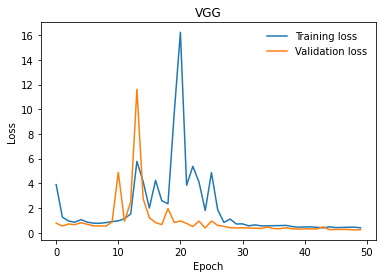

In [13]:
plt.plot(x, train_losses, label='Training loss')
plt.plot(x, val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title("VGG")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

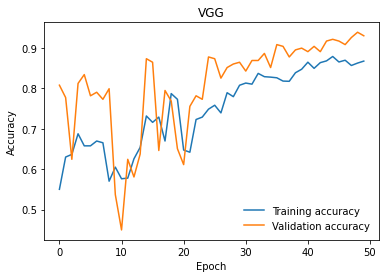

In [14]:
plt.plot(x, train_acc, label='Training accuracy')
plt.plot(x, val_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.title("VGG")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [15]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 3):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1) 
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=3, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None
    
    # Return everything
    return epoch_loss, epoch_top1_acc, epoch_top5_acc, predicted_labels

In [16]:
# set data dir to full image
# data_dir = "full_image"
# set data dir to crop image
data_dir = "images"
# get full image data as testing data
dataloaders, class_name = get_dataloaders(input_size, batch_size, True)

In [17]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss, val_top1, val_top5, val_labels = evaluate(model, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 3)

# Get predictions for the test set
epoch_loss, top1_acc, top5_acc, test_labels = evaluate(model, dataloaders['test'], criterion, is_labelled = True, generate_labels = True, k = 3)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:29<00:00,  1.96s/it]


In [18]:
top1_acc

0.8755364806866953

In [20]:
# data directory of cropped images
data_dir = "images"
class_names = ['normal',
            'abnormal',
            'tumor']

In [21]:
# initialize confusion matrix
confusion_matrix = {x: [0,0,0] for x in class_name}

In [22]:
# load cropped images 
input_size = 224
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data_dir,
                         transforms.Compose([
                             transforms.Resize(input_size),
                             transforms.CenterCrop(input_size),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ])),
    batch_size = 1,
    shuffle = False)

In [23]:
# move model to GPU
model = model.to(device)
running_top1_correct = 0
# generate confusion matrix on test data
loader = dataloaders['test']
# generate confusion matrix on all cropped data
# loader = train_loader
for inputs, labels in tqdm(loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # predict output
    outputs = model(inputs)
    _, preds = torch.topk(outputs, k=1, dim=1)
    # generate confusion matrix
    for i in range(len(labels)):
        original_label = int(labels[i])
        confusion_matrix[class_names[original_label]][int(preds[i])] += 1
        
    running_top1_correct += torch.sum(preds[:, 0] == labels.data)

epoch_top1_acc = float(running_top1_correct.double() / len(loader.dataset))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:30<00:00,  2.05s/it]


In [24]:
print(confusion_matrix)
# total accuracy
print(epoch_top1_acc)

{'abnormal': [5, 66, 5], 'normal': [85, 10, 2], 'tumor': [3, 6, 51]}
0.8669527896995708


In [25]:
percentage = {x: [y /sum(confusion_matrix[x]) for y in confusion_matrix[x]] for x in confusion_matrix.keys()}
percentage

{'abnormal': [0.06578947368421052, 0.868421052631579, 0.06578947368421052],
 'normal': [0.8762886597938144, 0.10309278350515463, 0.020618556701030927],
 'tumor': [0.05, 0.1, 0.85]}

In [26]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

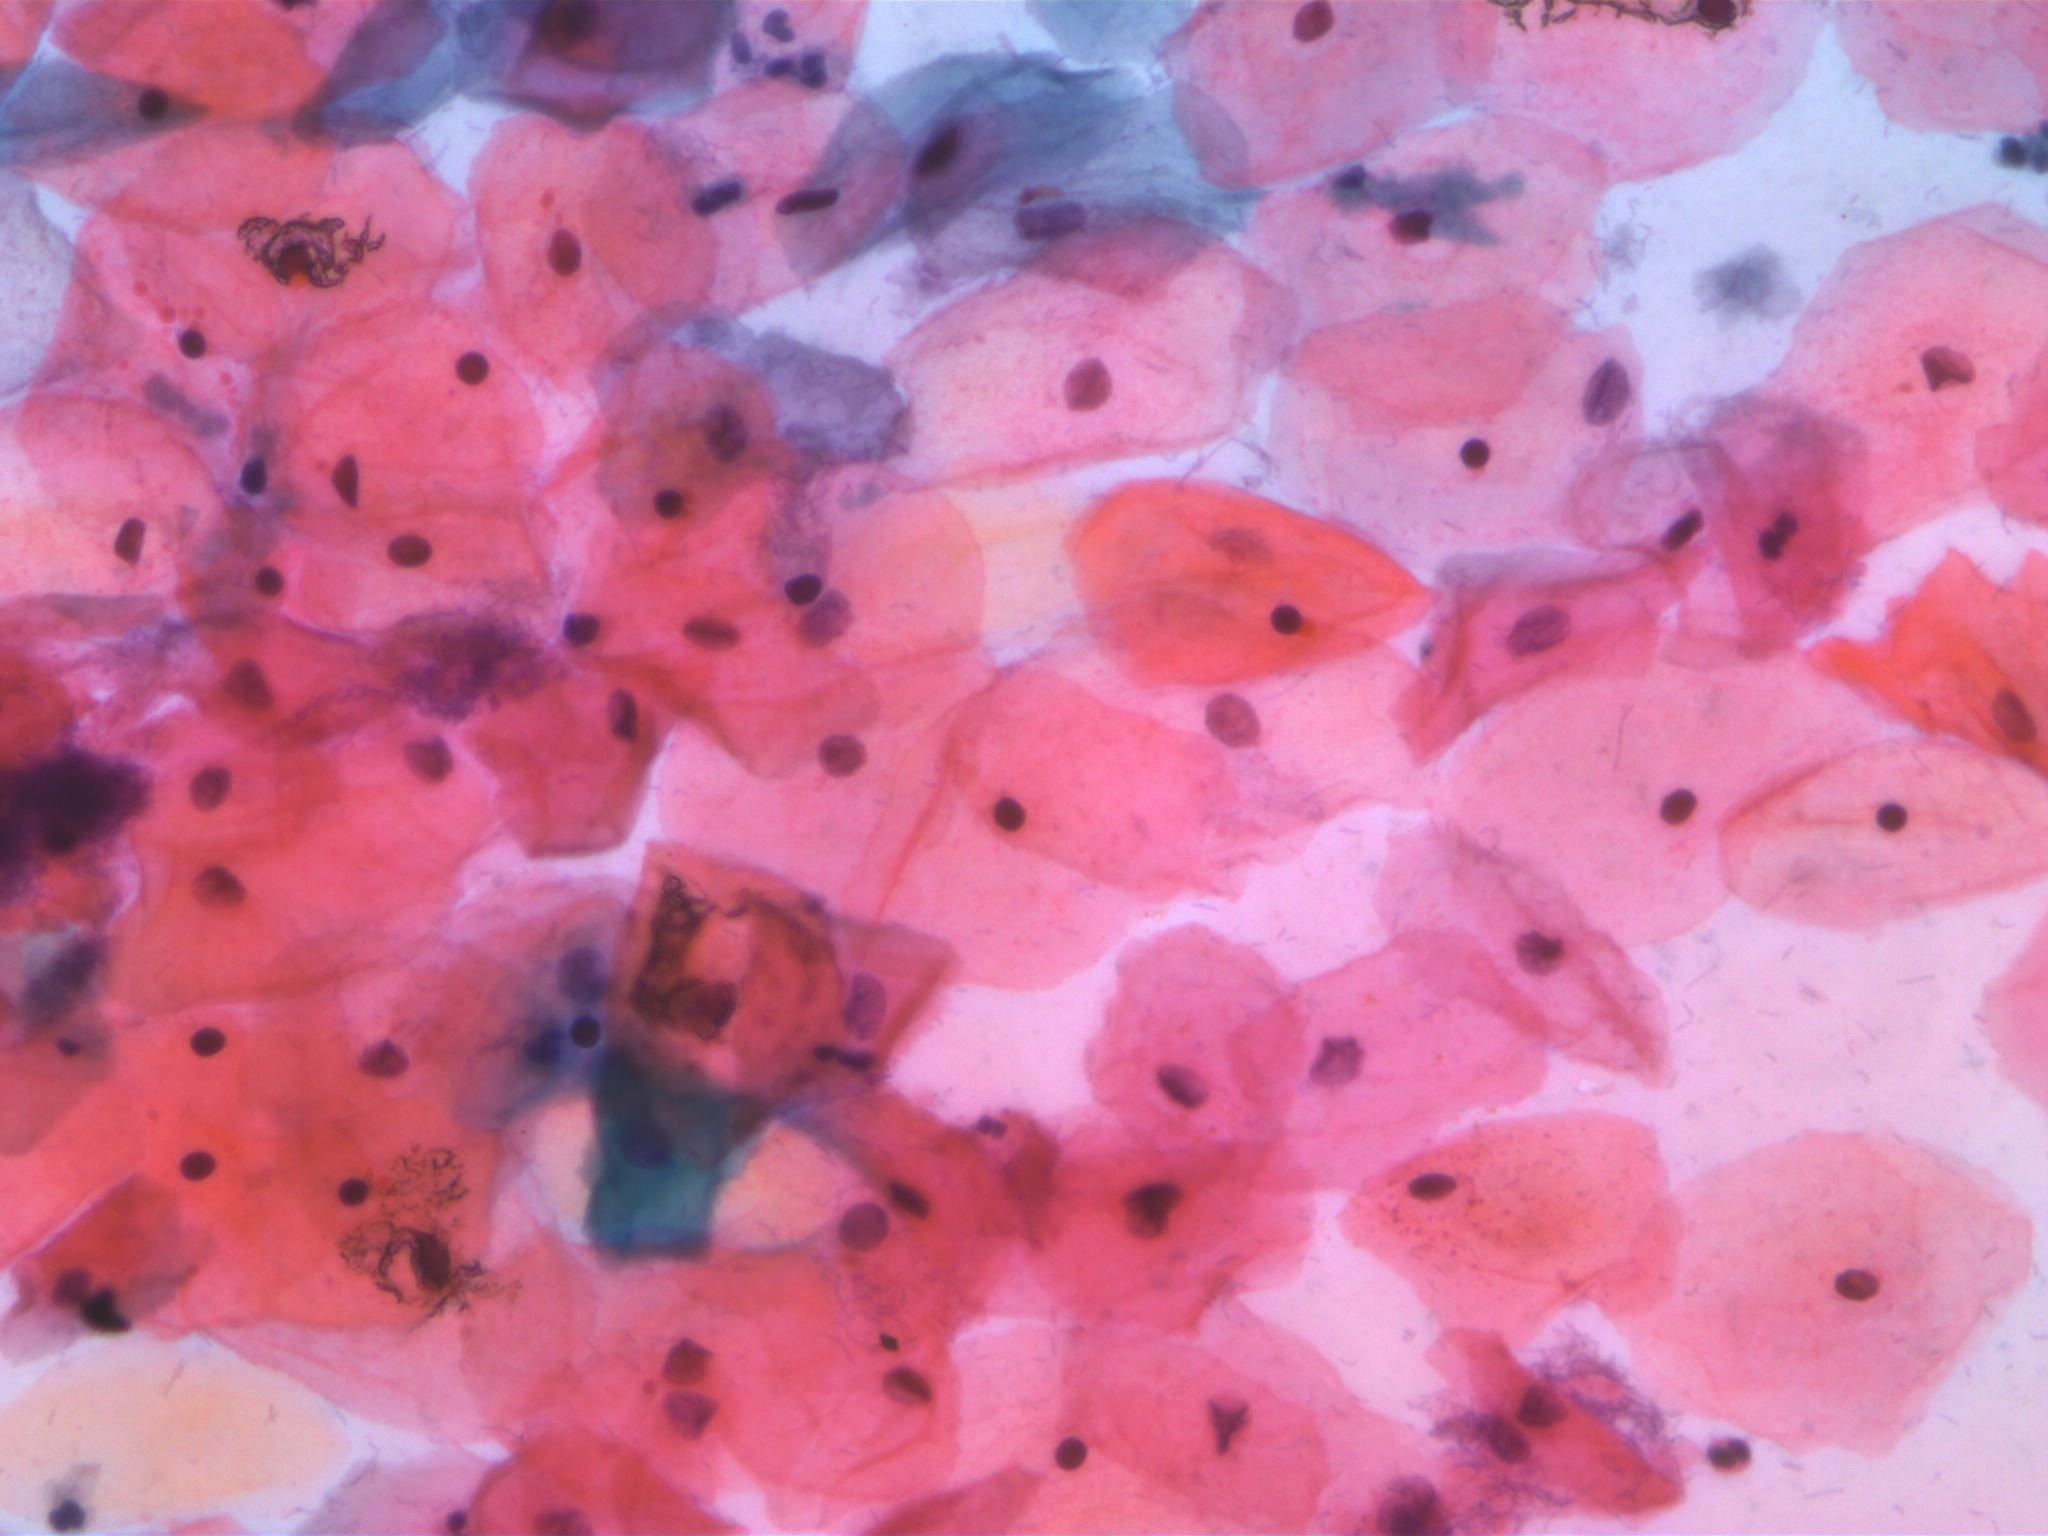

In [27]:
# view full image
img0 = PIL.Image.open('original_images/normal/40.bmp').convert('RGB')
img_numpy = np.array(img0)
showarray(img_numpy)

In [28]:
# shape of full image
img_numpy.shape

(1536, 2048, 3)

torch.Size([3, 256, 256])


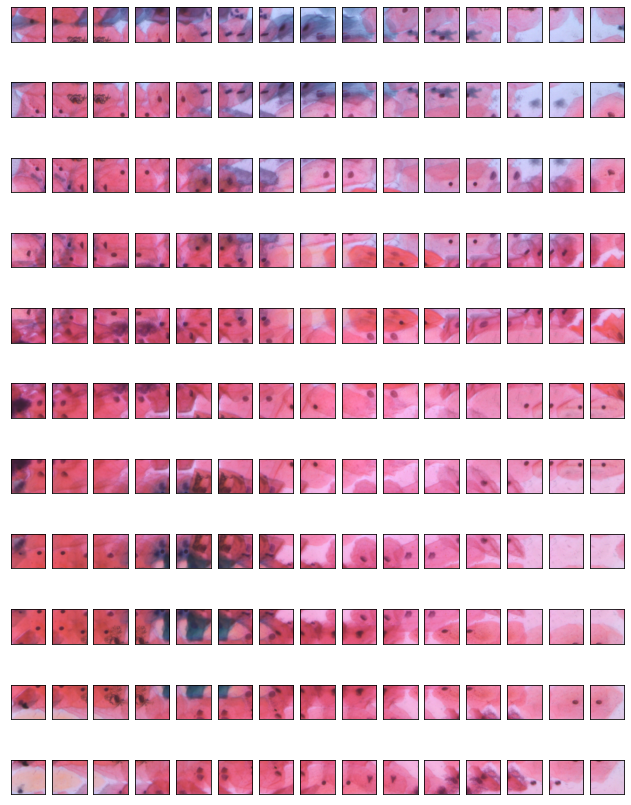

In [29]:
# patches = x.unfold(dim, size, stride).unfold(dim, size, stride).unfold(dim, size, stride)
transt = transforms.ToTensor()
transp = transforms.ToPILImage()
img_t = transt(PIL.Image.open('original_images/normal/40.bmp'))

#torch.Tensor.unfold(dimension, size, step)
#slices the images into 8*8 size patches
size = 256
stride = 128
# first color channel dimension, include all three
# width and height dimension find the common factor of the two for size and stride
patches = img_t.data.unfold(0, 3, 3).unfold(1, size, stride).unfold(2, size, stride)
print(patches[0][0][0].shape)

def visualize(patches):
    """Imshow for Tensor."""   
    # number of slices on height
    slice_h = patches.shape[1]
    slice_w = patches.shape[2]
    fig = plt.figure(figsize=(slice_h, slice_w))
    for i in range(patches.shape[1]):
        for j in range(patches.shape[2]):
            inp = transp(patches[0][i][j])
            inp = np.array(inp)
            ax = fig.add_subplot(slice_h, slice_w, ((i*slice_w)+j)+1, xticks=[], yticks=[])
            plt.imshow(inp)

visualize(patches)

In [30]:
patches.shape

torch.Size([1, 11, 15, 3, 256, 256])

normal: 0.49981820583343506


<ipython-input-31-f831a2a9d8d5>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = sm(prob)


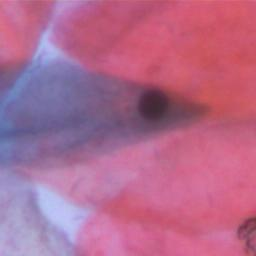

abnormal: 0.6759705543518066


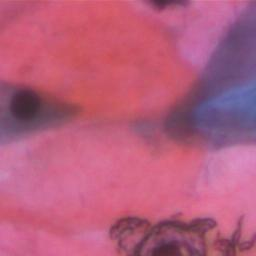

normal: 0.8944522738456726


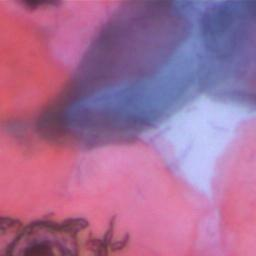

normal: 0.8538419604301453


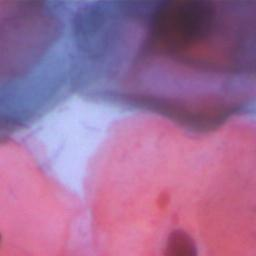

normal: 0.9249275326728821


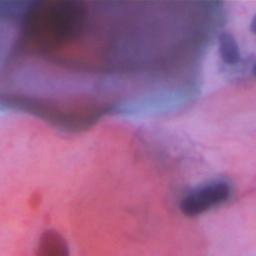

normal: 0.9772465229034424


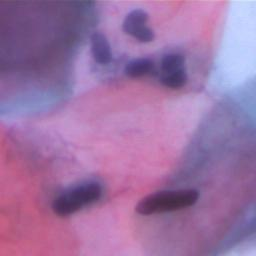

normal: 0.9458410143852234


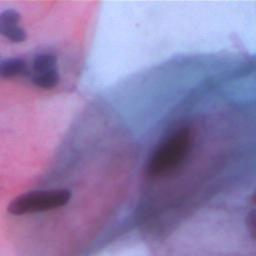

normal: 0.959243893623352


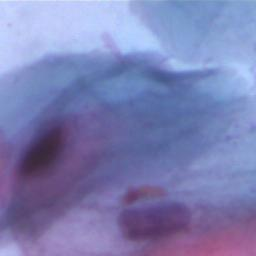

normal: 0.9672055840492249


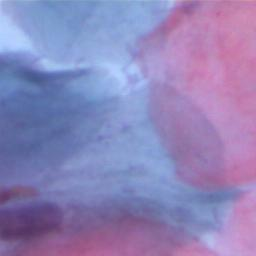

normal: 0.8192241787910461


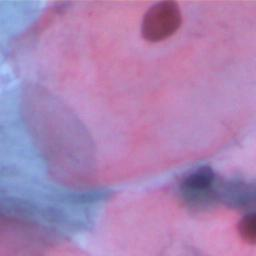

normal: 0.7288258075714111


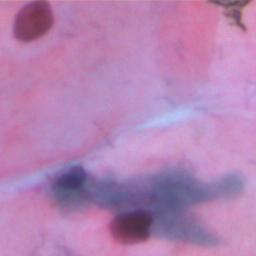

normal: 0.8254137635231018


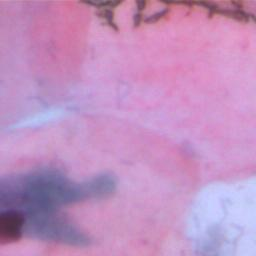

normal: 0.8117372989654541


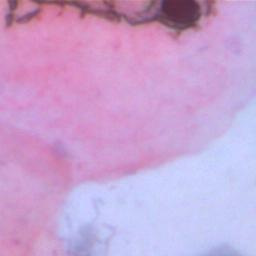

normal: 0.8460512757301331


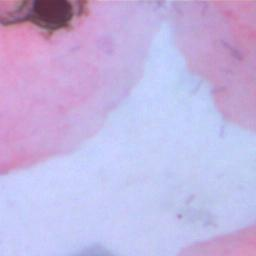

normal: 0.8802070021629333


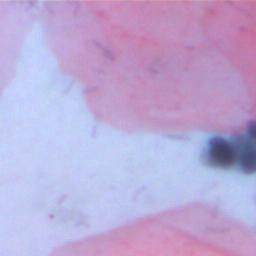

normal: 0.9547739624977112


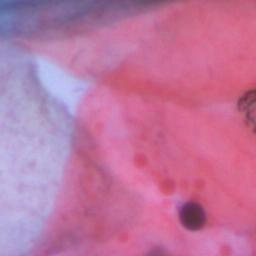

normal: 0.6450312733650208


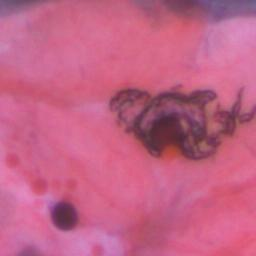

normal: 0.8505116105079651


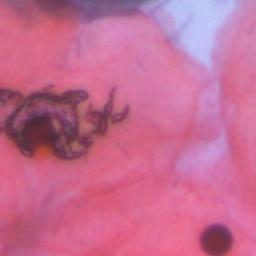

normal: 0.8448930978775024


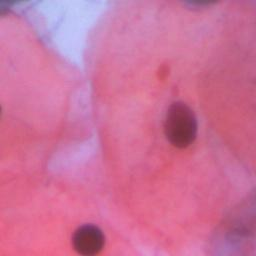

normal: 0.9731218218803406


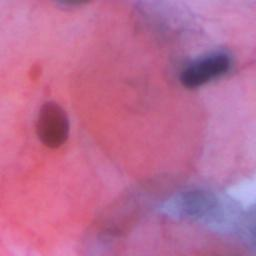

normal: 0.9439614415168762


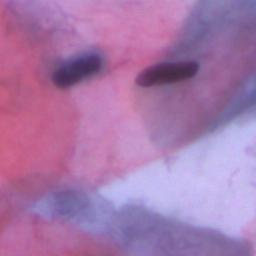

normal: 0.9414005875587463


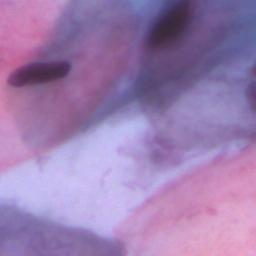

normal: 0.9859652519226074


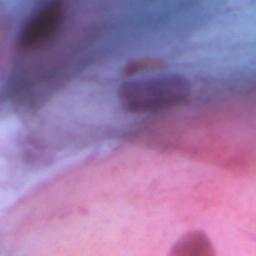

normal: 0.9802723526954651


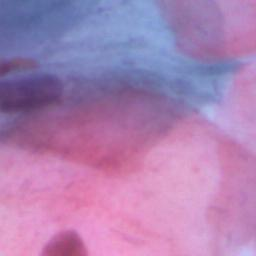

normal: 0.9495183229446411


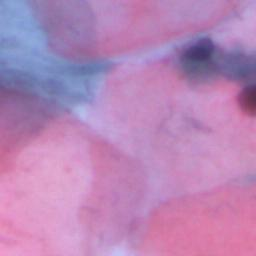

normal: 0.6888942122459412


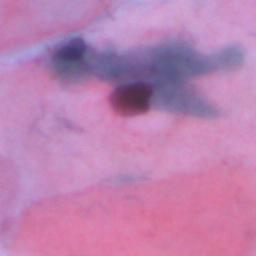

normal: 0.8574875593185425


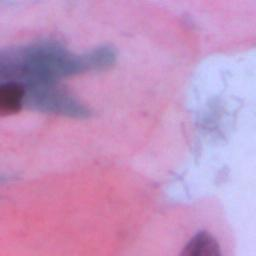

normal: 0.8108612895011902


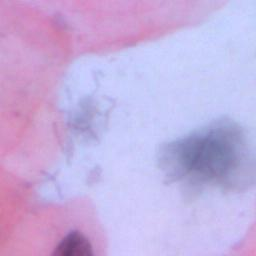

normal: 0.8556552529335022


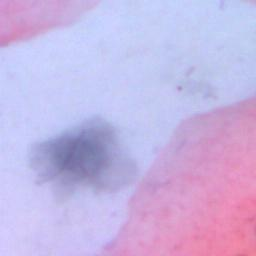

normal: 0.8238222599029541


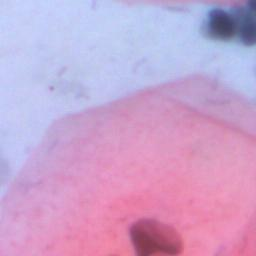

normal: 0.9748080372810364


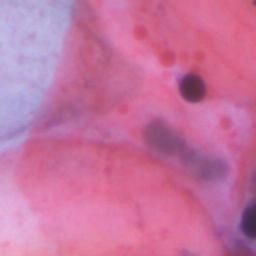

normal: 0.9700261950492859


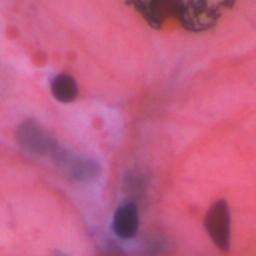

normal: 0.9486909508705139


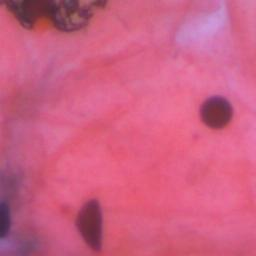

normal: 0.9275446534156799


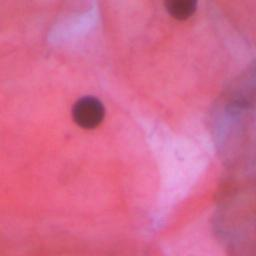

normal: 0.6128606796264648


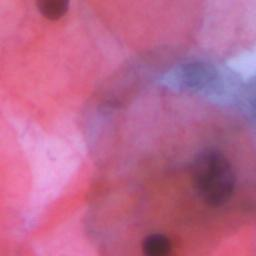

normal: 0.7080767750740051


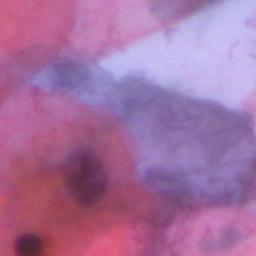

normal: 0.8829271793365479


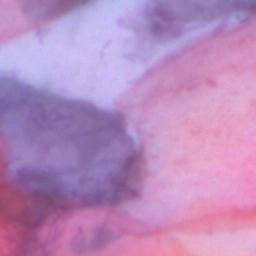

normal: 0.7197014093399048


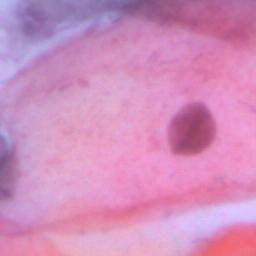

normal: 0.7854991555213928


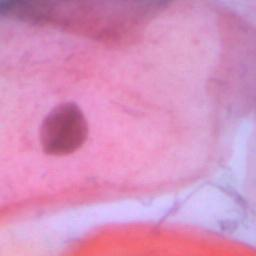

normal: 0.826217770576477


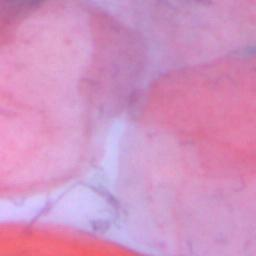

normal: 0.8581213355064392


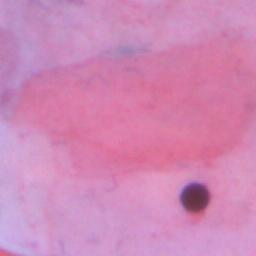

normal: 0.8465781211853027


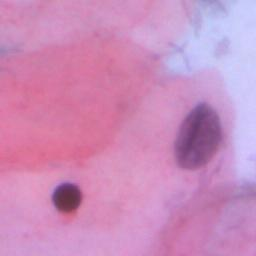

normal: 0.9143220782279968


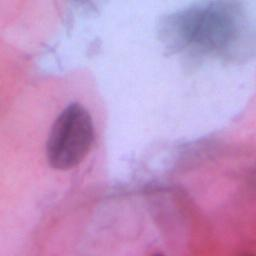

normal: 0.7167096138000488


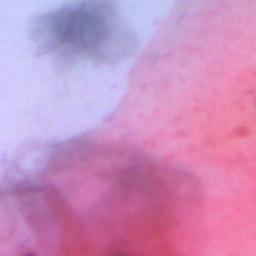

normal: 0.7621944546699524


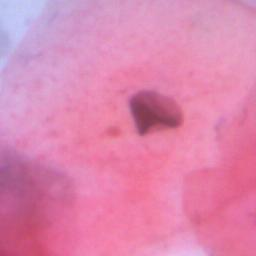

normal: 0.695651113986969


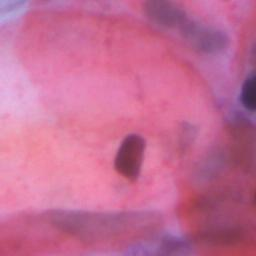

abnormal: 0.7125347852706909


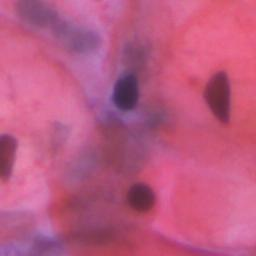

normal: 0.8736856579780579


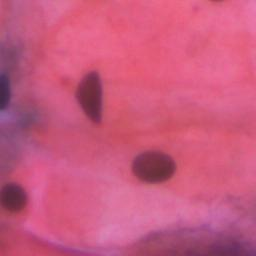

normal: 0.9752199649810791


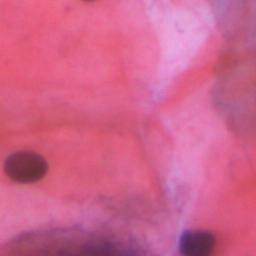

abnormal: 0.7849075794219971


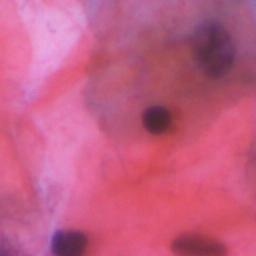

abnormal: 0.6755726337432861


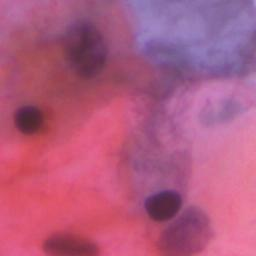

normal: 0.9201452136039734


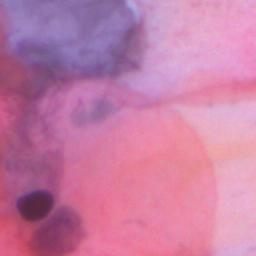

normal: 0.6999037861824036


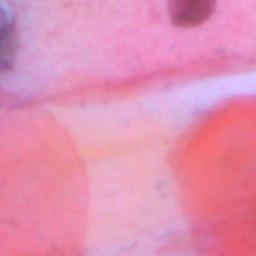

abnormal: 0.9480007886886597


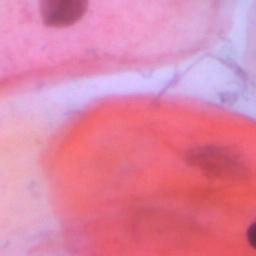

abnormal: 0.9045207500457764


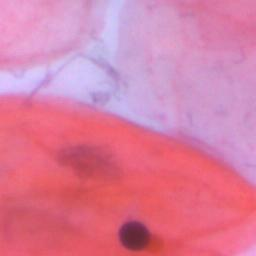

abnormal: 0.5580093860626221


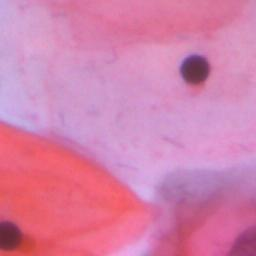

normal: 0.8145520687103271


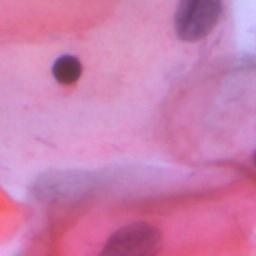

normal: 0.8682119250297546


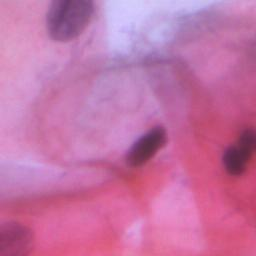

abnormal: 0.9114869832992554


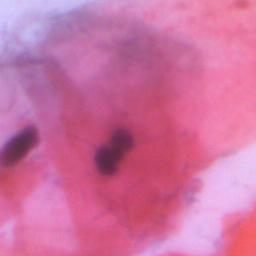

normal: 0.7055855393409729


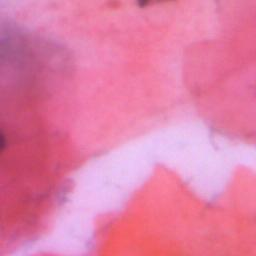

abnormal: 0.5315947532653809


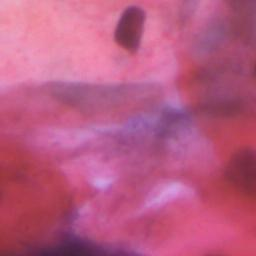

abnormal: 0.8642268776893616


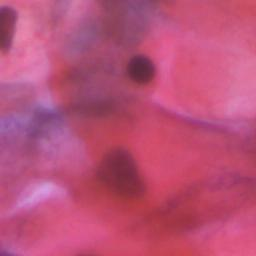

abnormal: 0.7575706243515015


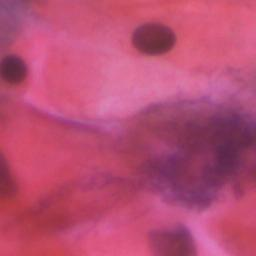

abnormal: 0.8484137058258057


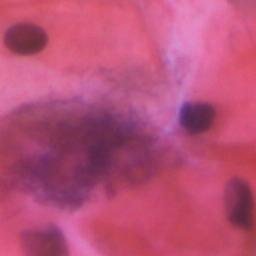

abnormal: 0.8617948889732361


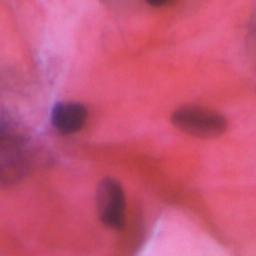

abnormal: 0.8137987852096558


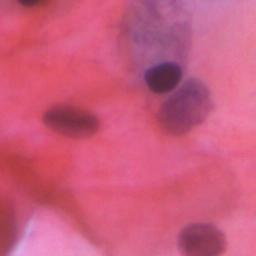

normal: 0.817240297794342


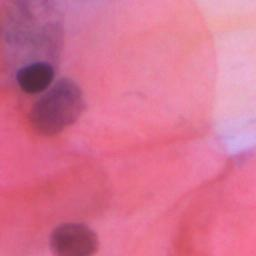

normal: 0.7801976799964905


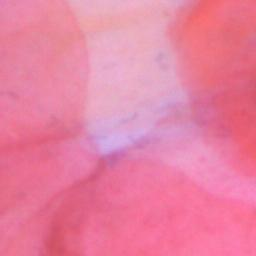

abnormal: 0.9068957567214966


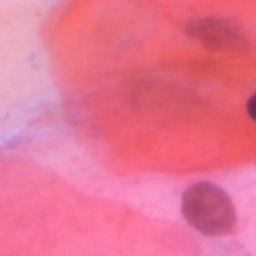

abnormal: 0.8540998101234436


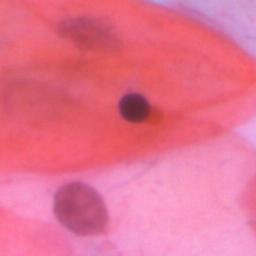

abnormal: 0.5389503836631775


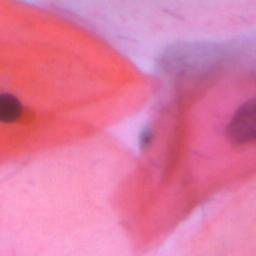

normal: 0.9265467524528503


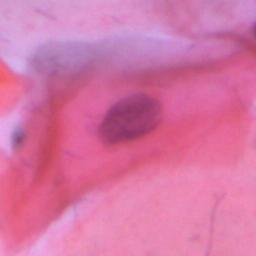

normal: 0.8880248069763184


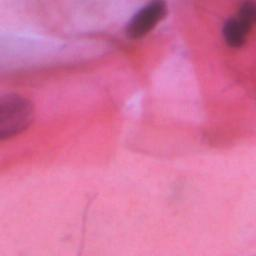

abnormal: 0.5552282929420471


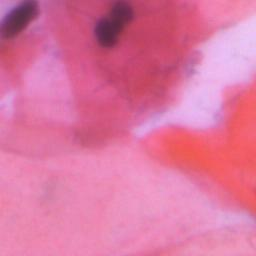

abnormal: 0.6356293559074402


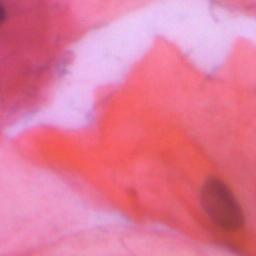

abnormal: 0.9393370747566223


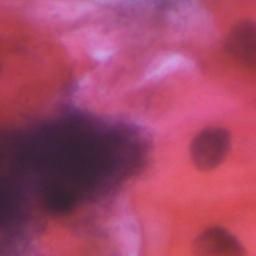

abnormal: 0.9301144480705261


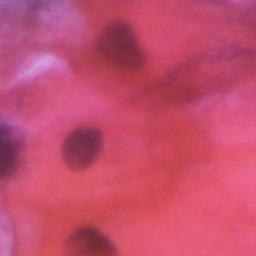

abnormal: 0.7894177436828613


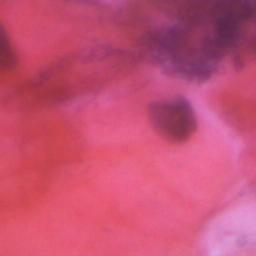

abnormal: 0.8796021938323975


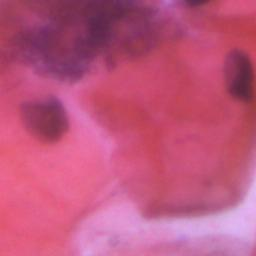

abnormal: 0.6889298558235168


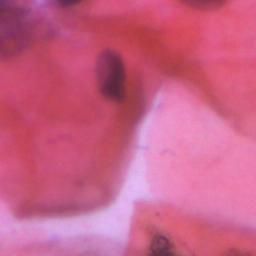

normal: 0.5572116374969482


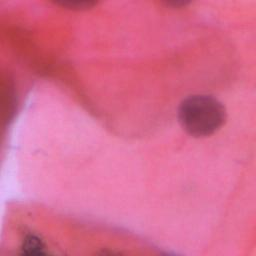

normal: 0.7928149104118347


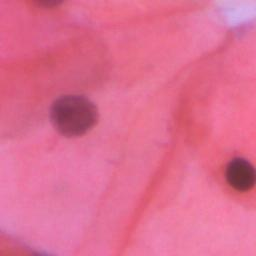

normal: 0.7085180878639221


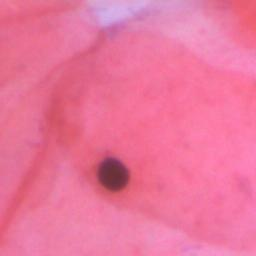

normal: 0.6307486891746521


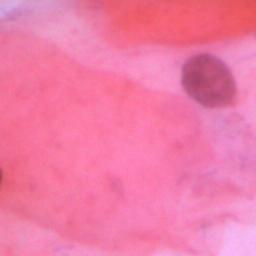

normal: 0.6653657555580139


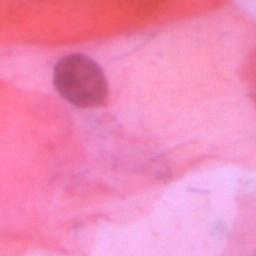

normal: 0.7725238800048828


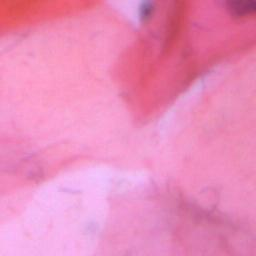

normal: 0.859878659248352


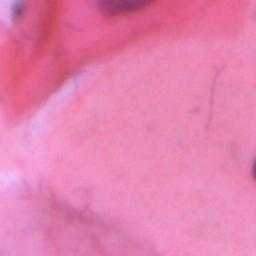

normal: 0.8132078051567078


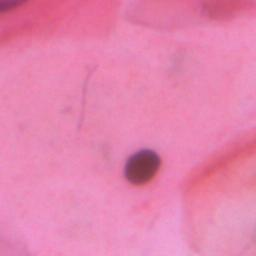

normal: 0.8229086399078369


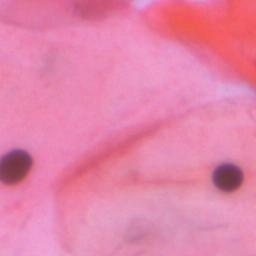

abnormal: 0.6229503750801086


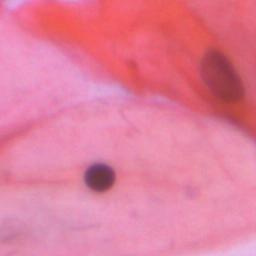

abnormal: 0.9295303225517273


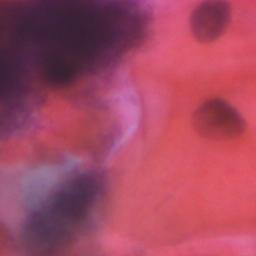

abnormal: 0.918359100818634


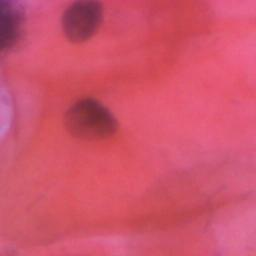

normal: 0.6643452048301697


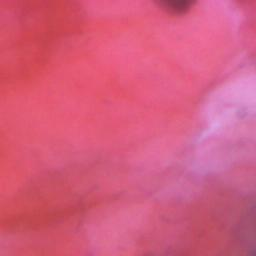

normal: 0.4758559763431549


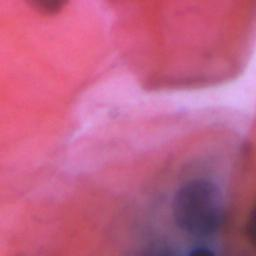

abnormal: 0.8544352650642395


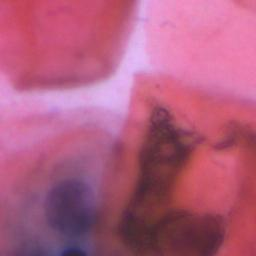

abnormal: 0.9926561117172241


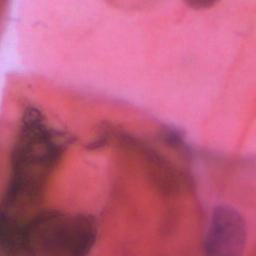

abnormal: 0.8166324496269226


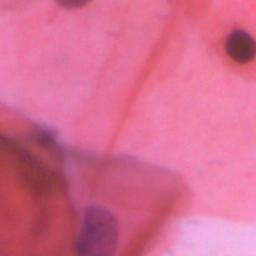

normal: 0.7330864071846008


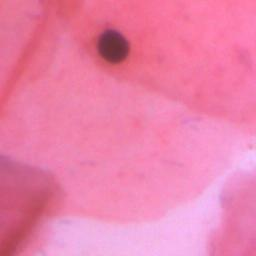

normal: 0.7931099534034729


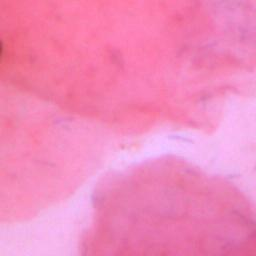

normal: 0.7717476487159729


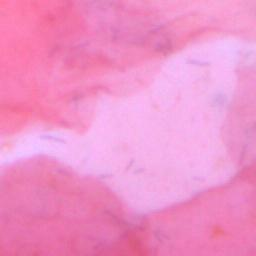

normal: 0.8196869492530823


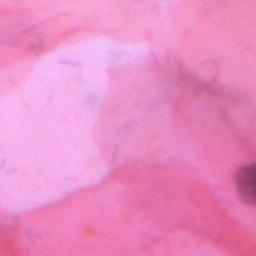

normal: 0.6800340414047241


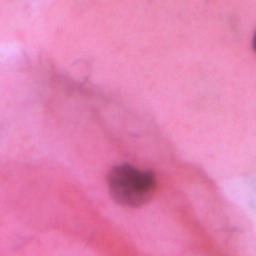

normal: 0.7884479761123657


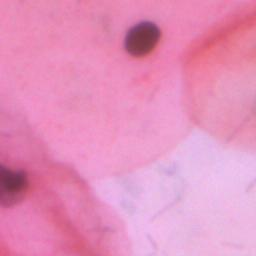

normal: 0.8527505993843079


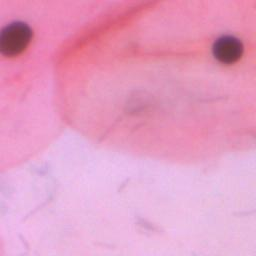

normal: 0.7925184369087219


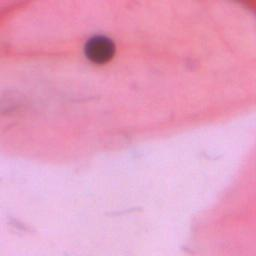

abnormal: 0.9502832293510437


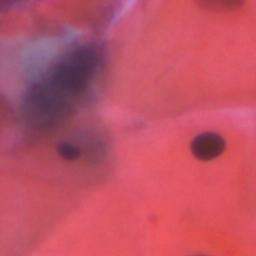

abnormal: 0.5807173848152161


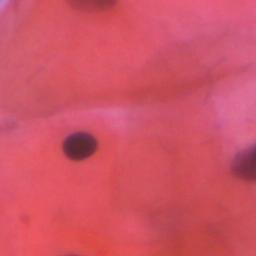

abnormal: 0.887377142906189


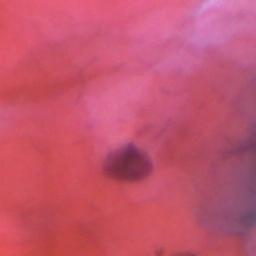

abnormal: 0.8890399932861328


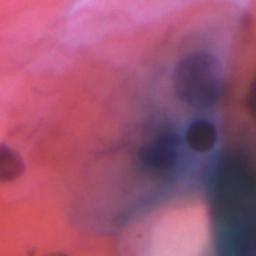

abnormal: 0.7499479651451111


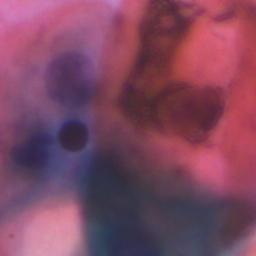

abnormal: 0.9708355069160461


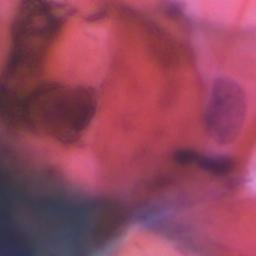

abnormal: 0.9622215628623962


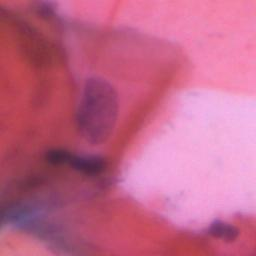

normal: 0.680233895778656


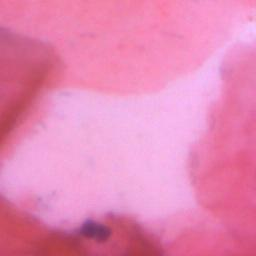

normal: 0.9202723503112793


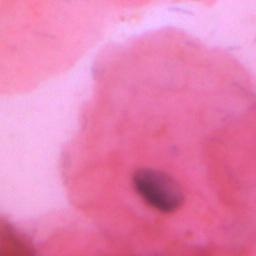

normal: 0.7073153853416443


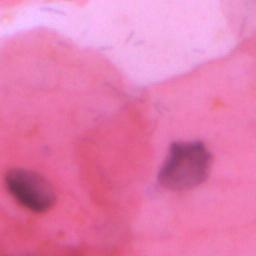

normal: 0.8119285702705383


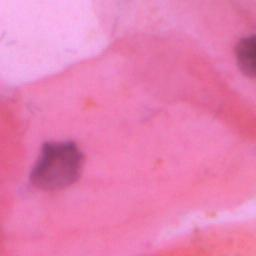

normal: 0.7261008024215698


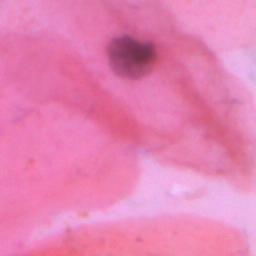

normal: 0.8518028259277344


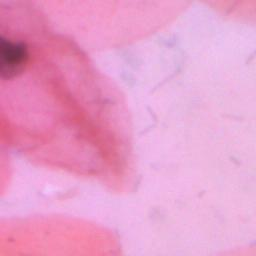

normal: 0.7932969331741333


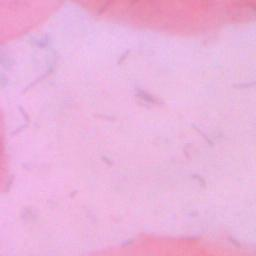

normal: 0.7910441756248474


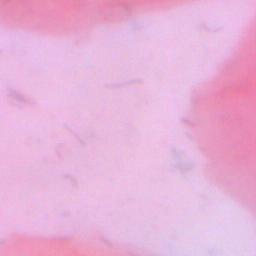

abnormal: 0.970752477645874


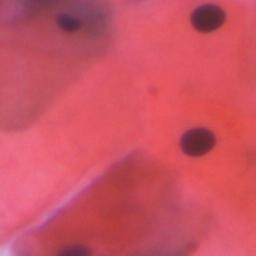

abnormal: 0.9999440908432007


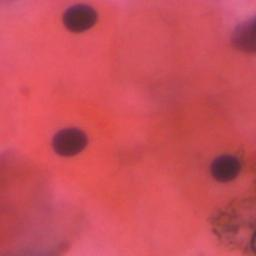

abnormal: 1.0


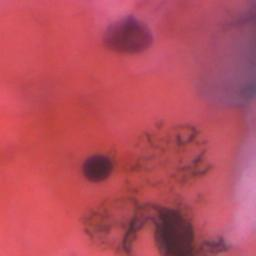

abnormal: 0.8642778992652893


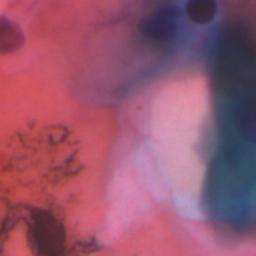

tumor: 0.6160230040550232


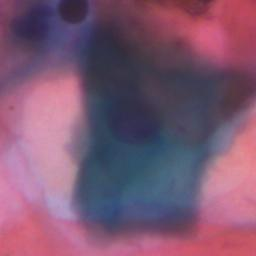

tumor: 0.4168325364589691


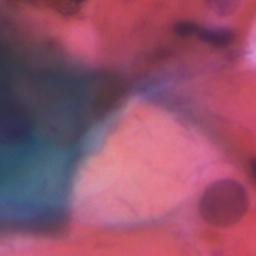

abnormal: 0.8957828879356384


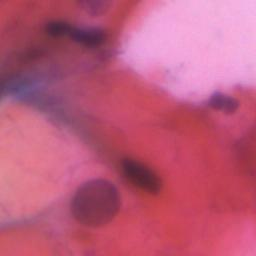

abnormal: 0.9476928114891052


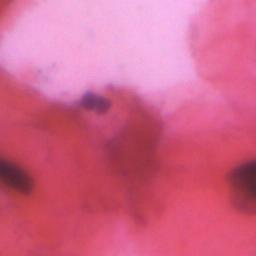

abnormal: 0.5968604683876038


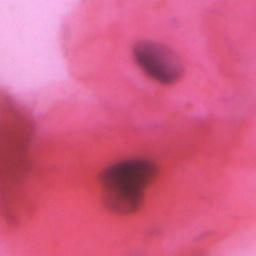

normal: 0.8721340894699097


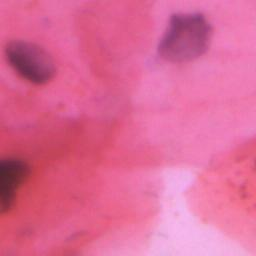

normal: 0.6721606850624084


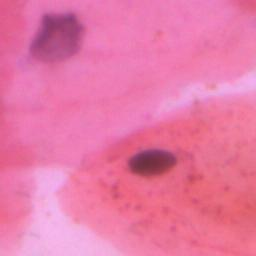

abnormal: 0.5935227870941162


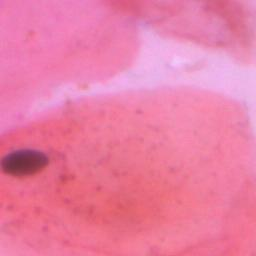

normal: 0.7723296284675598


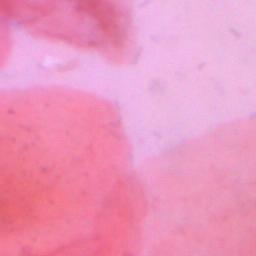

normal: 0.7867910265922546


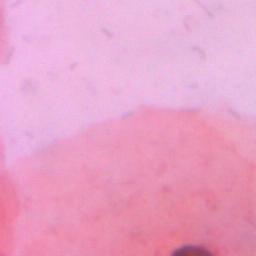

normal: 0.792975127696991


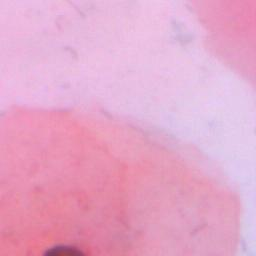

abnormal: 0.9999101161956787


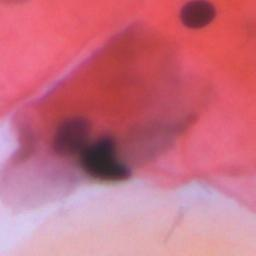

abnormal: 0.99741131067276


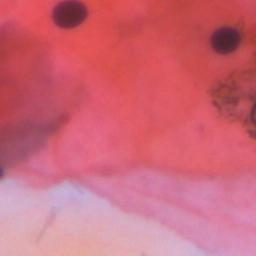

abnormal: 0.9999897480010986


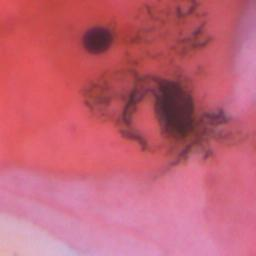

abnormal: 0.6327322721481323


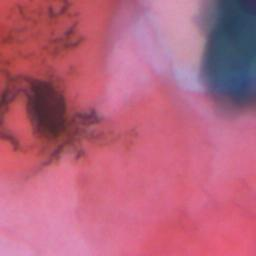

normal: 0.41108638048171997


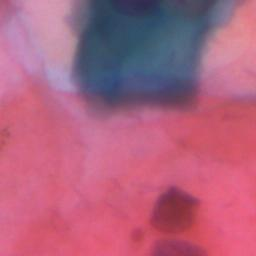

abnormal: 0.942886233329773


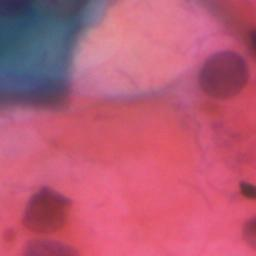

abnormal: 0.9323053956031799


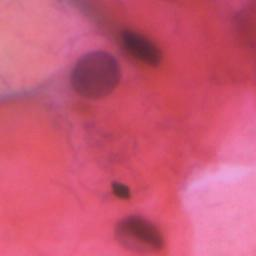

abnormal: 0.7262175679206848


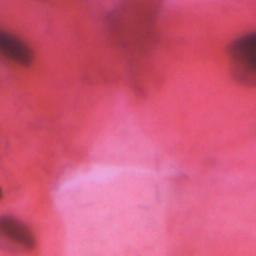

normal: 0.53571617603302


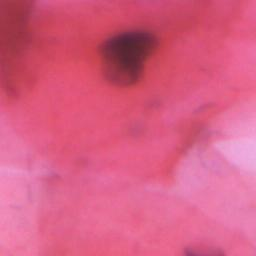

normal: 0.8371143937110901


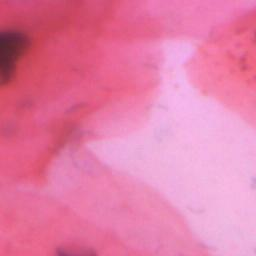

normal: 0.7230411767959595


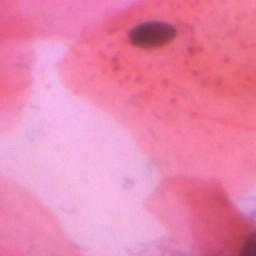

abnormal: 0.540889322757721


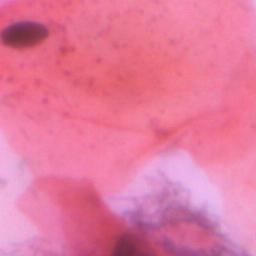

normal: 0.7751203775405884


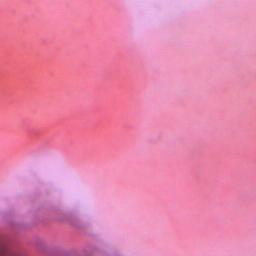

normal: 0.631310224533081


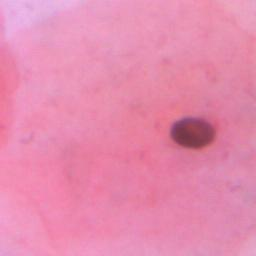

normal: 0.7924164533615112


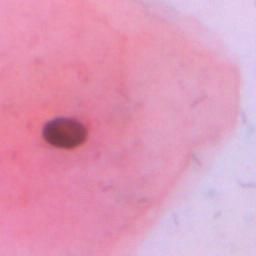

normal: 0.7136048674583435


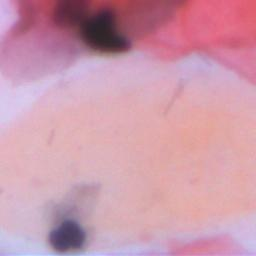

normal: 0.8695192933082581


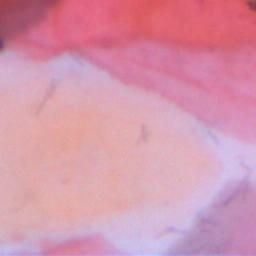

normal: 0.8301032781600952


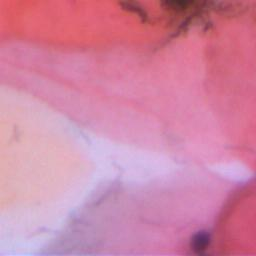

abnormal: 0.5591797232627869


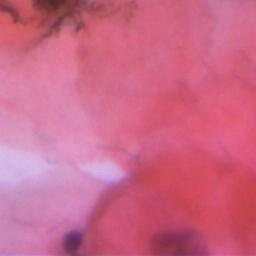

abnormal: 0.7228495478630066


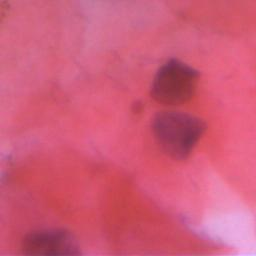

normal: 0.44657933712005615


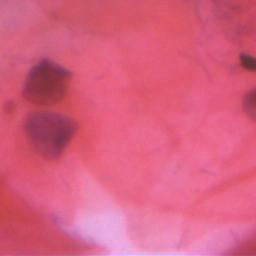

abnormal: 0.6576917767524719


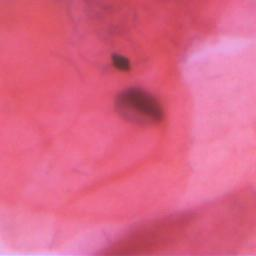

normal: 0.5422945618629456


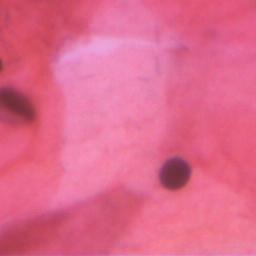

normal: 0.8010312914848328


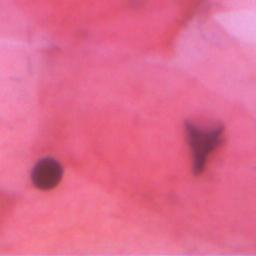

normal: 0.930447518825531


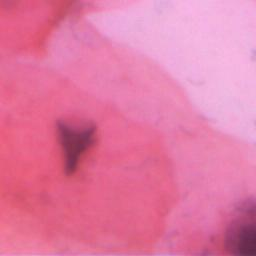

normal: 0.5756406784057617


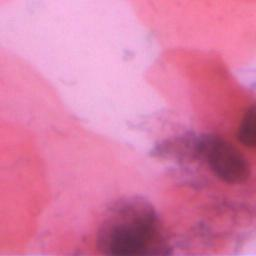

abnormal: 0.9007957577705383


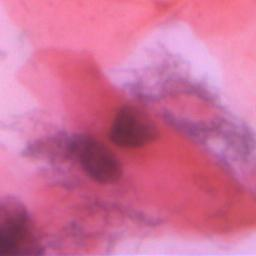

abnormal: 0.5270436406135559


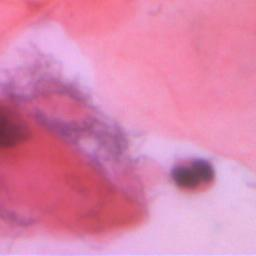

normal: 0.7714720368385315


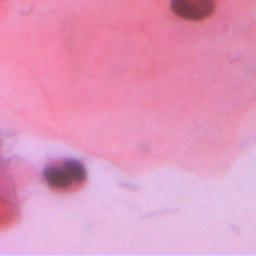

normal: 0.8449510335922241


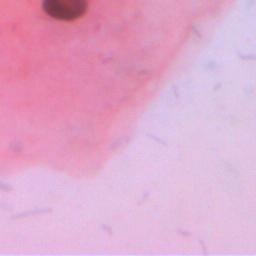

In [31]:
input_size = 224
for i in range(patches.shape[1]):
    for j in range(patches.shape[2]):
        normalize = transforms.Compose([
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # print image 
        
        # resize tensor to model input size
        x = F.interpolate(patches[0][i][j], size=224) 
        im = normalize(x)
        out = model(im.unsqueeze(0)).squeeze()
        # get the probability and category of top5 prediction
        prob, categories = out.topk(3)
        # convert the probability to softmax
        sm = torch.nn.Softmax()
        probabilities = sm(prob) 
        
        print(class_name[int(categories[0])] + ": " + str(float(probabilities[0])))
        inp = transp(patches[0][i][j])
        inp = np.array(inp)
        showarray(inp)